# Stalker, startup due dilligence automation

In [460]:
# Libraries
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy as sql 
from IPython.display import Image, display
# BeautifulSoup
from bs4 import BeautifulSoup as bs
from bs4.element import Comment
import urllib.request
from difflib import get_close_matches
import json
# Twitter sentiment analysis
import tweepy
from textblob import TextBlob
# News API
from newsapi import NewsApiClient
# Tldextract to get domain of url
import tldextract as tld
# NLTK to analyze webs
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Google search
from googlesearch import search

In [461]:
newsapi = NewsApiClient(api_key='f4b7461debe141aaa97906aaa15774e0')

In [462]:
news_sources = 'the-verge,buzzfeed,engadget,hacker-news,mashable,reddit-r-all,wired,techcrunch'

In [463]:
# Twitter API
consumer_key = 'z7JowVKfk7O7e91kqcAXTHvWm'
consumer_key_secret = '8KkTo5G3NhaX2gLIF3MMIl5Kb2U3N21kBrmb7pAEIMXBLRHDjo'
access_token = '266094721-7wiXyVFTvA5Zdsj5sNFiR5w2wokjROsT2bNrkb2w'
access_token_secret = 'huhhS6OCprQpyz6KDm5CQbXvymERJNP6wesztk0cmfn7m'

In [464]:
# News Api
newsapi = NewsApiClient(api_key='f4b7461debe141aaa97906aaa15774e0')
news_sources = 'the-verge,buzzfeed,engadget,hacker-news,mashable,reddit-r-all,wired,techcrunch'

# Twitter API
consumer_key = 'z7JowVKfk7O7e91kqcAXTHvWm'
consumer_key_secret = '8KkTo5G3NhaX2gLIF3MMIl5Kb2U3N21kBrmb7pAEIMXBLRHDjo'
access_token = '266094721-7wiXyVFTvA5Zdsj5sNFiR5w2wokjROsT2bNrkb2w'
access_token_secret = 'huhhS6OCprQpyz6KDm5CQbXvymERJNP6wesztk0cmfn7m'

auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [465]:
# Connect to database
from sqlalchemy import create_engine
driver = 'mysql+pymysql:'
user = 'alvaro'
password = 'stalvaro19962013'   
ip = '35.246.28.129'
database = 'data_crunch'
connection_string = f'{driver}//{user}:{password}@{ip}/{database}?charset=utf8'
engine = create_engine(connection_string)

In [466]:
# Get data from database
companies = pd.read_sql_table(table_name='companies15', con=connection_string)
investments = pd.read_sql_table(table_name='investments15', con=connection_string)
people = pd.read_sql_table(table_name='people', con=connection_string)
rounds = pd.read_sql_table(table_name='rounds15', con=connection_string)

In [467]:
investments = investments.dropna(subset=['raised_amount_usd', 'company_category_list'])
sector_list0 = []
sector_list = []
for item in investments['company_category_list']:
    if ',' in item:
        sector_list0.append(item.split(sep=', '))
    else:
        sector_list0.append(item)
for i in sector_list0:
    if type(i) == list:
        for sec in i:
            sector_list.append(sec)

    else:
        sector_list.append(i)

In [468]:
companies_list = []
for i in companies.dropna(subset=['name']).name:
    companies_list.append(i)

## Google search

In [469]:
# Finding related urls

def find_webs(query):
    urls = []
    rrss = ['facebook', 'twitter', 'linkedin', 'instagram', 'youtube','pinterest','angel']
    sites = []
    red_social = False
    for s in search(query, tld="com", num=30, stop=30, pause=3, lang='en'):

        if len(urls)<10:
            for rs in rrss:
                if rs in s or tld.extract(s).domain in sites:
                    red_social = True
            if not red_social and s not in urls:
                urls.append(s)
                sites.append(tld.extract(s).domain)  

            red_social = False
    return urls

In [470]:
def tag_visible(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
        return False
    if isinstance(element, Comment):
        return False
    return True


def text_from_html(body):
    soup = bs(body, 'html.parser')
    texts = soup.findAll(text=True)
    visible_texts = filter(tag_visible, texts)  
    return u" ".join(t.strip() for t in visible_texts)

In [471]:
def finding_nemo(urls):
    # Define words that trigger a warning
    warning_word = ['lie', 'fraud', 'scam', 'extortion', 'deceit', 'crime','arson', 'assault', 'bigamy', 'blackmail',
                'bribery', 'burglary', 'child abuse', 'conspiracy', 'espionage', 'forgery', 'fraud', 'genocide', 
                'hijacking','homicide', 'kidnapping', 'manslaughter', 'mugging', 'murder', 'perjury', 'rape', 'riot',
                'robbery', 'shoplifting', 'slander', 'smuggling', 'treason', 'trespassing']
    # URLs with a warning
    black_urls = []
    # Find 
    for i in urls:
        try:
            html = text_from_html(urllib.request.urlopen(i).read())
            stop_words = set(stopwords.words('english')) 
            word_tokens = word_tokenize(html)
            filtered_sentence = [w for w in word_tokens if not w in stop_words]

            for warning in warning_word:
                if warning in filtered_sentence and i not in black_urls:
                    black_urls.append(i)
                    print(f'We found something sketchy. You might want to check this link: {i}\n')
        except:
            print(f'{i} ha fallado\n')


## Getting info about the company from the user

In [472]:
def retrieve_name(my_name):
    
    if my_name in companies_list:
        return my_name
    elif len(get_close_matches(my_name, companies_list)) > 0:
        action = input("Did you mean %s instead? [y or n]: " % get_close_matches(my_name, companies_list)[0])
        if (action == "y"):
            return get_close_matches(my_name, companies_list)[0]
        elif (action == "n"):
            return my_name
        else:
            return("we don't understand you. Apologies.")

In [473]:
name0 = input('Name of the company: ')
name = retrieve_name(name0)

Name of the company: Theranos


In [474]:
def retrieve_sector(my_sector):
    
    if my_sector in sector_list:
        return my_sector
    elif len(get_close_matches(my_sector, sector_list)) > 0:
        action = input("Did you mean %s instead? [y or n]: " % get_close_matches(my_sector, sector_list) [0])
        if (action == "y"):
            return get_close_matches(my_sector, sector_list)[0]
        else:
            return my_sector

In [475]:
sector0 = input('In what sector is this company working?: ')
sector = retrieve_sector(sector0)

In what sector is this company working?: Biotechnology


In [476]:
founder = input('What is the name of the founder?: ')

What is the name of the founder?: Elizabeth Holmes


## Looking for info in Crunchbase

In [477]:
# Sentiment analysis tweeter
def tw_sent_sector(public_tweets):    
    sentiment_list = []
    for tweet in public_tweets:
        analysis = TextBlob(tweet.text)
        sentiment_list.append(analysis.sentiment[0])
    if sum(sentiment_list)>0:
         sent = 'Positive'
    elif sum(sentiment_list)<0:
        sent = 'Negative'
    else:
        sent = 'Neutral'
    print(f"The sentiment about {sector} industry in Twitter is {sent}")

In [478]:
# Sentiment analysis news
def news_sentiment_sector(public_news):
    news_list = []
    for piece in range(len(public_news['articles'])):
        news_list.append(TextBlob(public_news['articles'][piece]['title']).sentiment[0])
        news_list.append(TextBlob(public_news['articles'][piece]['description']).sentiment[0]) 
    if sum(news_list)>0:
        news_sent = 'Positive'
    elif sum(news_list)<0:
        news_sent = 'Negative'
    else:
        news_sent = 'Neutral'
    print(f"There have been {len(public_news)} news pieces about {sector} industry recently and are in general {news_sent}")

In [480]:
def category(sector):
    # Gather tweets
    public_tweets = api.search(sector)
    
    # Gather news
    public_news = newsapi.get_everything(q=sector,sources=news_sources,language='en')
    
    # Prepare the data for the sector
    sector_investments = investments[investments['company_category_list'].str.contains(sector)].drop('index',axis=1)
    sector_investments.reset_index(drop=True)
    sector_investments['funded_at'] = pd.to_datetime(sector_investments['funded_at'])
    sector_investments['Year'] = sector_investments['funded_at'].apply(lambda x: x.year )
    sector_investments['Month'] = sector_investments['funded_at'].apply(lambda x: x.month )
    sector_investments['Day'] = sector_investments['funded_at'].apply(lambda x: x.day )
    
    # Sentiment analysis Twitter
    tw_sent_sector(public_tweets)
    
    # Sentiment analysis News
    news_sentiment_sector(public_news)
    
    # create plot
    sector_year = sector_investments.groupby(['Year']).sum()[-10:]
    movement = ((sector_year.raised_amount_usd.iloc[len(sector_year)-1] - sector_year.raised_amount_usd.iloc[0])/sector_year.raised_amount_usd.iloc[0]*100)
    if sector_year.raised_amount_usd.iloc[0] + sector_year.raised_amount_usd.iloc[len(sector_year)-1] >= 0:
        in_dec = 'increased'
        grow = 'growing'
    else:
        in_dec = 'decreased'
        grow = 'falling'
        movement = movement[1:]
    sns.lineplot(x=sector_year.index, y=sector_year.raised_amount_usd).set_title(f'Evolution of the amount invested in {sector}')
    peak_year =  sector_year.index[sector_year['raised_amount_usd']== max(sector_year.raised_amount_usd)].to_list()
    peak_amount = max(sector_year.raised_amount_usd)
    low_amount = min(sector_year.raised_amount_usd)
    low_year = sector_year.index[sector_year['raised_amount_usd']== min(sector_year.raised_amount_usd)].to_list()
    format_doll = ',.2f'
    print(f"""The amount of money invested in {sector} companies has {in_dec} by {format(abs(movement),format_doll)}% in the last {len(sector_year)} years, 
it is expected to keep {grow} by X the next  X years. 
It peaked in year {peak_year} with ${format(peak_amount,format_doll)} invested and its lowest point was in year {low_year} with ${format(low_amount,format_doll)} invested.""")
    plt.ylabel('Raised amount in USD')
    plt.show()
    investments_per_year = sector_investments.groupby(['Year']).count()
    sns.lineplot(x=investments_per_year.index[-10:], y=investments_per_year.Day[-10:]).set_title(f'Evolution of the number of investment in {sector}')
    plt.ylabel('Number of investments')
    print("""Plot explanaition average investment
    
    """)
    plt.show()

The sentiment about Biotechnology industry in Twitter is Positive
There have been 3 news pieces about Biotechnology industry recently and are in general Positive
The amount of money invested in Biotechnology companies has increased by 203.11% in the last 10 years, 
it is expected to keep growing by X the next  X years. 
It peaked in year [2015] with $48,271,810,280.06 invested and its lowest point was in year [2006] with $15,925,340,476.99 invested.


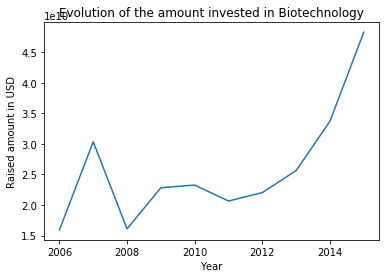

Plot explanaition average investment
    
    


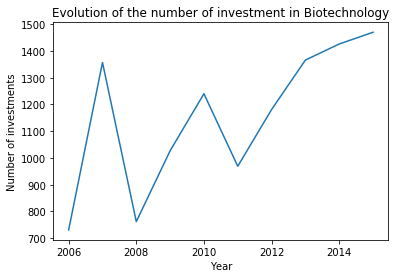

In [481]:
category(sector)

In [482]:
 # Sentiment analysis
def tw_analysis_founder(public_tweets):
    sentiment_list = []
    for tweet in public_tweets:
        analysis = TextBlob(tweet.text)
        sentiment_list.append(analysis.sentiment[0])
    if sum(sentiment_list)>0:
         sent = 'Positive'
    elif sum(sentiment_list)<0:
        sent = 'Negative'
    else:
        sent = 'Neutral'
    print(f"The sentiment about {founder} in Twitter is {sent}")
            

In [483]:
def founders(founder):
    full_name = founder.split()
    public_tweets = api.search(founder)
    for i in range(len(people)):
        if people.first_name.iloc[i] == full_name[0] and people.last_name.iloc[i]==full_name[1]:
            display(Image(url=people.profile_image_url[i]))
            print(f'We found this information about {founder}:')
            print(f"Founder's name: {people.first_name[i]} {people.last_name[i]} ")
            print(f"Title: {people.title[i]}")
            print(f"Organization: {people.organization[i]}")
            print(f"Location: {people.location_city[i]}, {people.location_region[i]}, {people.location_country_code[i]}")
            if people.twitter_url[i] != None:
                print(f"Twitter URL: {people.twitter_url[i]}")
            if people.linkedin_url[i] != None:
                print(f"Linkedin URL: {people.linkedin_url[i]}")
            if people.facebook_url[i] != None:
                print(f"Facebook URL: {people.facebook_url[i]}")
    # Twitter analysis
    tw_analysis_founder(public_tweets)
    # Google search
    google_founder = find_webs(founder)
    finding_nemo(google_founder)
    

In [484]:
founders(founder)

We found this information about Elizabeth Holmes:
Founder's name: Elizabeth Holmes 
Title: Founder and CEO at Theranos
Organization: Theranos
Location: Palo Alto, California, US
Twitter URL: https://twitter.com/eholmes2003
Facebook URL: https://www.facebook.com/elizabeth.holmes.16121471
The sentiment about Elizabeth Holmes in Twitter is Positive
We found something sketchy. You might want to check this link: https://en.wikipedia.org/wiki/Elizabeth_Holmes

We found something sketchy. You might want to check this link: https://www.biography.com/business-figure/elizabeth-holmes

We found something sketchy. You might want to check this link: https://www.cnbc.com/2018/05/22/stories-from-bad-blood-book-on-theranos-and-elizabeth-holmes.html

We found something sketchy. You might want to check this link: https://www.vanityfair.com/news/2016/09/elizabeth-holmes-theranos-exclusive

We found something sketchy. You might want to check this link: https://www.businessinsider.com/theranos-founder-ceo-

In [569]:
def startup(name):
    company = companies[companies['name'] == name]
    #display(Image(url=company.profile_image_url))
    print(f"Company name: {company.name.item()}")
    print(f"Total money raised: ${format(company.funding_total_usd.item(),',.2f')}")
    print(f"Total rounds: {company.funding_rounds.item()}")
    print(f"Status: {company.status.item()}")
    # Find competitors
    print('\n')
    print(f"Competitors similar to {company.name.item()}:")
    print('\n')
    competitor_info(find_companies_by_size('small'))
    print('\n')      
    competitor_info(find_companies_by_size('medium'))
    print('\n')     
    competitor_info(find_companies_by_size('big'))
    # Google search
    #google_startup = find_webs(name)
    #finding_nemo(google_startup)
    
    

In [559]:
startup(name)

Company name: Theranos
Total money raised: $88,400,000.00
Total rounds: 5
Status: operating


Competitors similar to Theranos:


Company name: Vinomis Laboratories
Total money raised: $600,613.00
Total rounds: 2
Webpage: http://vinomis.com
Country: USA
Status: operating
Founded in: 2009-01-01


Company name: Imprimis Pharmaceuticals
Total money raised: $22,946,180.00
Total rounds: 2
Webpage: http://imprimispharma.com
Country: USA
Status: ipo
Founded in: 1998-01-01


Company name: EdeniQ
Total money raised: $111,670,000.00
Total rounds: 7
Webpage: http://www.edeniq.com
Country: USA
Status: operating
Founded in: 2008-01-01


### To improve
> Message if cannot find info

> Suggestions (Difflib) (founder)

> Twitter feed with stats (NO)

> Google Search with warning analysis select only most relevant links 


In [566]:
def find_companies_by_size(size):
    company_nan = companies.dropna()
    company_sector = company_nan[company_nan['category_list'].str.contains(sector)].drop('index',axis=1).dropna()
    company_sector['total_funding_size']=pd.qcut(company_sector.funding_total_usd, q=[0, .25, .75, 1], labels=['small', 'medium', 'big'])
    if name in company_nan['name']:
        return company_sector[(company_sector['total_funding_size']==size)& (company_sector['funding_total_usd'] > 100000) & (company_sector['status'] != 'closed')& (company_sector['country_code']==company.country_code)].sample()
    else:     
        return company_sector[(company_sector['total_funding_size']==size)& (company_sector['funding_total_usd'] > 100000) & (company_sector['status'] != 'closed')].sample()

In [567]:
find_companies_by_size('small')

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,total_funding_size
28031,/organization/inspire-2,Inspire,http://www.inspire.com,Biotechnology|Communities|Health and Wellness|...,375000.0,operating,USA,NJ,Newark,Princeton,1,2005-01-01,2011-09-07,2011-09-07,small


In [526]:
def competitor_info(company):
    print(f"Company name: {company.name.item()}")
    print(f"Total money raised: ${format(company.funding_total_usd.item(),',.2f')}")
    print(f"Total rounds: {company.funding_rounds.item()}")
    print(f"Webpage: {company.homepage_url.item()}")
    print(f"Country: {company.country_code.item()}")
    print(f"Status: {company.status.item()}")
    print(f"Founded in: {company.founded_at.item()}")
    

In [568]:
competitor_info(find_companies_by_size('small'))

Company name: ProZyme
Total money raised: $321,414.00
Total rounds: 1
Webpage: http://prozyme.com
Country: USA
Status: operating
Founded in: 1990-01-01


In [499]:
company_sector[(company_sector['total_funding_size']=='small')&(company_sector['funding_total_usd'] > 0) & (company_sector['status'] == 'operating')]


,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,total_funding_size
6,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,http://ondinebio.com,Biotechnology,7.628510e+05,operating,CAN,BC,Vancouver,Vancouver,2,1997-01-01,2009-09-11,2009-12-21,small
224,/organization/360imaging,360imaging,http://www.360imaging.com,Biotechnology|Dental,1.000000e+06,operating,USA,GA,Atlanta,Atlanta,2,2005-01-01,2011-11-01,2013-01-01,small
247,/organization/3ci,3CI,http://www.3ci.bz.it/en-US/Products.html,Biotechnology,1.336200e+05,operating,ITA,6,Bolzano,Bolzano,1,2008-01-01,2011-01-01,2011-01-01,small
253,/organization/3d-biomatrix,3D Biomatrix,http://3dbiomatrix.com,Biotechnology,1.465000e+06,operating,USA,MI,Detroit,Ann Arbor,2,2010-01-01,2009-10-05,2013-02-05,small
366,/organization/4deep,4Deep,http://4-deep.com/,Biotechnology,5.000000e+05,operating,CAN,NS,Halifax,Halifax,1,2008-01-01,2015-11-20,2015-11-20,small
488,/organization/7-oaks-pharmaceutical,7 Oaks Pharmaceutical,http://bensalhprx.com,Biotechnology,1.613014e+06,operating,USA,SC,Greenville - Spartanburg,Easley,1,1997-01-01,2011-06-06,2011-06-06,small
701,/organization/abcelex-technologies,AbCelex Technologies,http://www.abcelex.com/,Biotechnology,2.000000e+06,operating,CAN,ON,Toronto,Mississauga,1,2010-01-01,2014-04-28,2014-04-28,small
715,/organization/abide-therapeutics,Abide Therapeutics,http://abidetx.com,Biotechnology,2.250180e+06,operating,USA,NJ,Newark,Princeton,1,2011-01-01,2011-11-18,2011-11-18,small
724,/organization/abiobot,aBioBot,http://abiobot.org/,Biotechnology|Robotics|Technology,5.000000e+04,operating,USA,OH,"Columbus, Ohio",Dublin,1,2015-01-01,2015-02-03,2015-02-03,small
782,/organization/absynth-biologics,Absynth Biologics,http://absynthbiologics.co.uk,Biotechnology,1.663801e+06,operating,GBR,L9,Sheffield,Sheffield,2,2007-01-01,2013-07-18,2015-11-30,small
